<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_Stacked_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$: Derivada do torque do robô (variação do torque com o tempo).[R_d_T]
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $\frac{d\omega_{l}}{dt}$: Derivada da velocidade da coroa  (variação da velocidade da coroa com o tempo). [R_d_w_l]
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$: Ângulo do motor na perna esquerda .[L_t_m]
- $\theta_{l, L}$: Ângulo da coroa na perna esquerda .[L_t_l]
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$: Torque real no lado esquerdo .[L_T_r]
- $\tau^{d}_{r, L}$: Torque desejado no lado esquerdo . [L_T_d]

# Bibliotecas

In [1]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [4]:
drive.mount('/content/drive')
t6_markov =  "drive/MyDrive/Markov/T6/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t6 = pd.read_table(t6_markov, header=None, names=head_markov, index_col=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = markov_t6.iloc[1275:]
# Remover linhas onde R_w_l é zero
data = data.loc[data['R_w_l'] != 0]

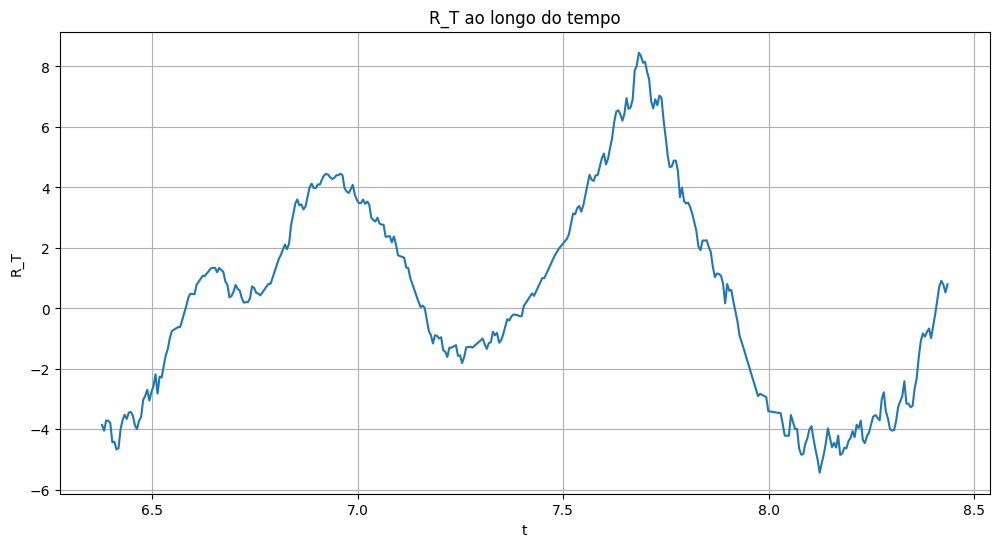

In [6]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(data['t'].iloc[:350], data['R_T'].iloc[:350])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

# 2º Passo: Cálculo do torque de interação τ_i

In [7]:
Ka = 0.1  # Rigidez do acessório
Ba = 1   # Amortecimento do acessório
data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
data['d_tau_i'] = np.gradient(data['tau_i'])

# 3º Passo: Separação e Normalização dos dados


In [8]:
dataset = data.copy()
X = dataset[['R_t_p', 'R_t_l', 'R_w_p', 'R_w_l', 'phase']]  # Inputs
y = dataset[['R_T_d']]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [9]:
timesteps = 420  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (9073, 420, 5)
Forma dos dados de saída: (9073, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [10]:
# Modelo Stacked Bidirectional LSTM
model_bilstm = Sequential()

# Primeira camada Bidirectional LSTM
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(timesteps, n_features)))
model_bilstm.add(Dropout(0.2))

# Segunda camada Bidirectional LSTM
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=False)))
model_bilstm.add(Dropout(0.2))

# Camada densa final
model_bilstm.add(Dense(1))

# Compilar
model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=Huber(), metrics=['MAE', 'MSE'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 6º Passo: Treinamento do Modelo

In [11]:
# Treinamento
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=256,
    batch_size=32,
    validation_split=0.4,
    verbose = 1
    )

Epoch 1/256
171/171 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - MAE: 0.0916 - MSE: 0.0180 - loss: 0.0090 - val_MAE: 0.0698 - val_MSE: 0.0087 - val_loss: 0.0044
Epoch 2/256
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - MAE: 0.0496 - MSE: 0.0040 - loss: 0.0020 - val_MAE: 0.0643 - val_MSE: 0.0067 - val_loss: 0.0033
Epoch 3/256
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - MAE: 0.0456 - MSE: 0.0035 - loss: 0.0018 - val_MAE: 0.0549 - val_MSE: 0.0053 - val_loss: 0.0026
Epoch 4/256
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - MAE: 0.0426 - MSE: 0.0031 - loss: 0.0015 - val_MAE: 0.0637 - val_MSE: 0.0072 - val_loss: 0.0036
Epoch 5/256
171/171 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - MAE: 0.0429 - MSE: 0.0031 - loss: 0.0016 - val_MAE: 0.0655 - val_MSE: 0.0076 - val_loss: 0.0038
Epoch 6/256
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - MAE: 0.0388 - MSE: 0.0026 - loss: 0.0013 - val_MAE: 0.0563 - val_MSE: 0.0051 - val_loss: 0.0025
Epoch 7/256
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - MAE: 0.0390 - MSE: 0.0025

# 7º Passo: Avaliação e Previsão

In [12]:
# Previsões
y_pred_bilstm = scaler_y.inverse_transform(model_bilstm.predict(X_train))
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas BiLSTM
r2_bilstm = r2_score(y_train_rescaled, y_pred_bilstm)
mae_bilstm = mean_absolute_error(y_train_rescaled, y_pred_bilstm)
rmse_bilstm = np.sqrt(mean_squared_error(y_train_rescaled, y_pred_bilstm))

print("\nResultados Stacked BiLSTM:")
print(f'R²: {r2_bilstm}')
print(f'MAE: {mae_bilstm}')
print(f'RMSE: {rmse_bilstm}')

284/284 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step

Resultados Stacked BiLSTM:
R²: 0.9410182790299783
MAE: 0.2559176656099722
RMSE: 0.4457243419592646


# 8º Passo: Visualização das perdas (train vs validation)

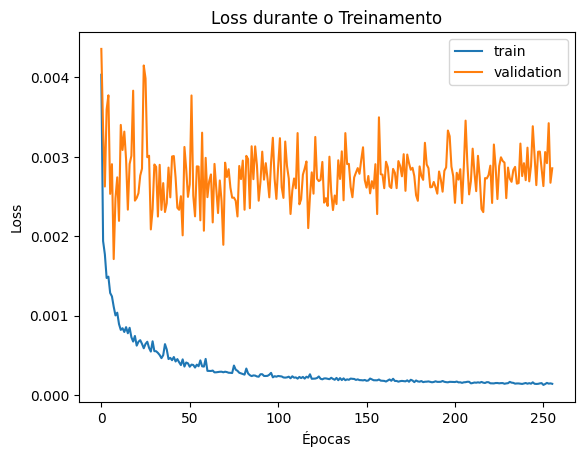

In [13]:
plt.plot(history_bilstm.history['loss'], label='train')
plt.plot(history_bilstm.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

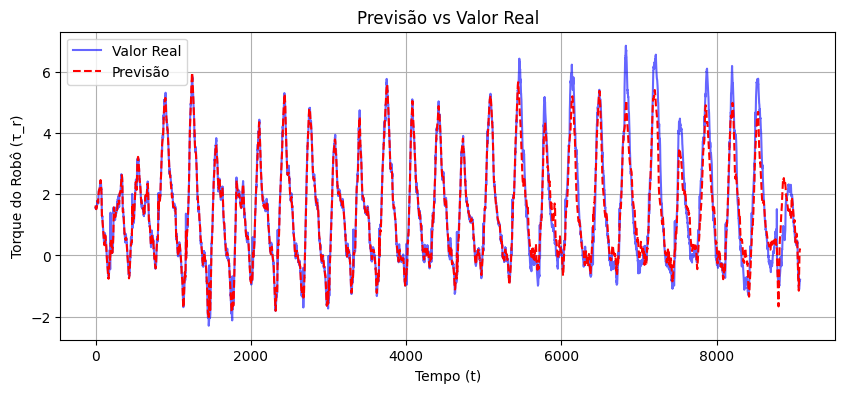

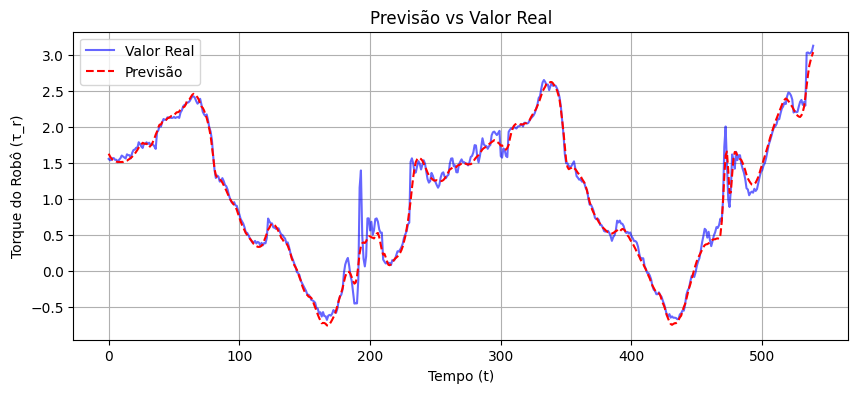

In [17]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[:], y_pred_bilstm[:])
plot_predictions(y_train_rescaled[:540], y_pred_bilstm[:540])

# 10º Passo: Erro

In [18]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred_bilstm.flatten()

#11º Passo: Plot do Erro

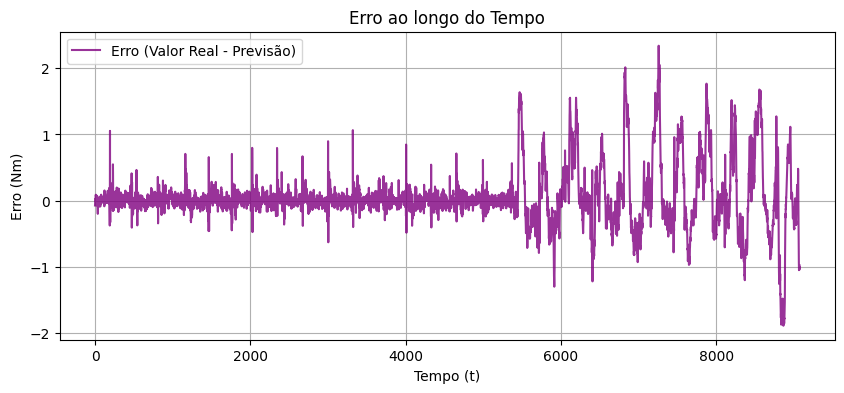

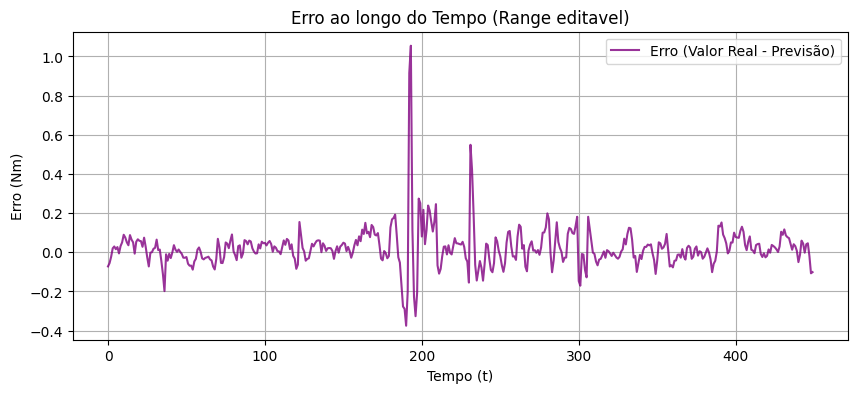

Média do Erro: 0.0525 Nm
Desvio Padrão do Erro: 0.4426 Nm


In [19]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:450], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')

In [20]:
model_bilstm.evaluate(X_train, y_train, verbose=2)
model_bilstm.save('drive/MyDrive/Markov/Modelo BI LSTM/model_bi_lstm_Markov6.h5')
model_bilstm.save_weights('drive/MyDrive/Markov/Modelo BI LSTM/model_bi_lstm_weights_Markov6.weights.h5')
json_string = model_bilstm.to_json()
json_string

284/284 - 7s - 25ms/step - MAE: 0.0279 - MSE: 0.0024 - loss: 0.0012


'{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 420, 5], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Bidirectional", "config": {"name": "bidirectional", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "merge_mode": "concat", "layer": {"module": "keras.layers", "class_name": "LSTM", "config": {"name": "forward_lstm", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "z